In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'used-car-price-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3742543%2F6478229%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240704%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240704T025945Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1756430c83c659218749d71c759908e77582ae02fbac16c3dc38c94f30787763ba67fd94d8b3cd640eeffc1cd4d099f8ede065075d7c41ddc31e578670a3091508dd6448db2d805bf0997af48a4af8e4dff7e225bba3f7b4ba2a90f0fc87dcf260a5fb79b0b8d9916a3a75f6ef715c7a8075397d737fe276065b651b9fbf69d67f436766d11d0fb4f92353e7e5f28ee36783df25f5bb01580ce41301777db519434d9b5543e685ccf1d74a4fa10c222473469b1da6b1acd5bf4d7ddd6ade6b834d5378c6eff4a37811b6d1fabef665f7846f5e65528aa2acab47810fccdb142dfb6b968fcf9242e0073a1cf529f3fe2d7edf3543ac88da1938e72ac49d540274'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112006 bytes downloaded
Downloaded and uncompressed: used-car-price-prediction-dataset
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-car-price-prediction-dataset/used_cars.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('ggplot')
pd.options.display.max_columns=100
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv(os.path.join(dirname, filename))

In [ ]:
df.sample(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
390,Volkswagen,Arteon 2.0T SE,2021,"13,613 mi.",Gasoline,2.0 Liter TSI,Automatic,Pure White,Titan Black,None reported,NaN,"$29,798"
1885,Land,Rover Range Rover P530 SE LWB 7 Seat,2023,"2,100 mi.",Gasoline,523.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Beige,None reported,Yes,"$172,000"


In [ ]:
df.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [ ]:
df=df.drop(['model','ext_col','int_col','clean_title'],axis=1,errors='ignore')

In [ ]:
df['model_year']=df['model_year'].astype(int)

In [ ]:
df['milage']=df['milage'].apply(lambda x:int(x.split('mi')[0].replace(',','')))

In [ ]:
df['fuel_type'].value_counts(normalize=True)

fuel_type
Gasoline          0.861943
Hybrid            0.050534
E85 Flex Fuel     0.036207
Diesel            0.030216
–                 0.011722
Plug-In Hybrid    0.008856
not supported     0.000521
Name: proportion, dtype: float64

In [ ]:
df['fuel_type']=df['fuel_type'].apply(lambda x:
                                      np.nan if str(x).strip()=='–' else
                                      'electric' if str(x).strip()=='not supported' else x)

In [ ]:
hp=df['engine'].apply(lambda x:x.split('HP')[0]).apply(pd.to_numeric,errors='coerce')
liters=df['engine'].apply(lambda x:x.split('L')[0].split('Liter')[0].split(' ')[-1]).apply(pd.to_numeric,errors='coerce')

df['HP']=hp
df['Engine Volume (L)']=liters

df=df.drop(columns='engine')

In [ ]:
df['transmission']=df['transmission'].str.contains('A/T|Automatic',case=False).astype(str)

In [ ]:
df['accident']=df['accident'].apply(lambda x:0 if 'None' in str(x) else 1)

In [ ]:
df['price']=df['price'].apply(lambda x:x.replace('$','').replace(',','')).apply(pd.to_numeric)

In [ ]:
df

,brand,model_year,milage,fuel_type,transmission,accident,price,HP,Engine Volume (L)
0,Ford,2013,51000,E85 Flex Fuel,True,1,10300,300.0,3.7
1,Hyundai,2021,34742,Gasoline,True,1,38005,NaN,3.8
2,Lexus,2022,22372,Gasoline,True,0,54598,NaN,NaN
3,INFINITI,2015,88900,Hybrid,True,0,15500,354.0,3.5
4,Audi,2021,9835,Gasoline,True,0,34999,NaN,2.0
...,...,...,...,...,...,...,...,...,...
4004,Bentley,2023,714,Gasoline,True,0,349950,NaN,6.0
4005,Audi,2022,10900,Gasoline,False,0,53900,349.0,3.0
4006,Porsche,2022,2116,NaN,True,0,90998,NaN,NaN
4007,Ford,2020,33000,Gasoline,True,0,62999,450.0,3.5


In [ ]:
df.isna().mean()*100

brand                 0.000000
model_year            0.000000
milage                0.000000
fuel_type             5.362933
transmission          0.000000
accident              0.000000
price                 0.000000
HP                   20.204540
Engine Volume (L)     9.428785
dtype: float64

In [ ]:
df.nunique()

brand                  57
model_year             34
milage               2818
fuel_type               6
transmission            2
accident                2
price                1569
HP                    348
Engine Volume (L)      61
dtype: int64

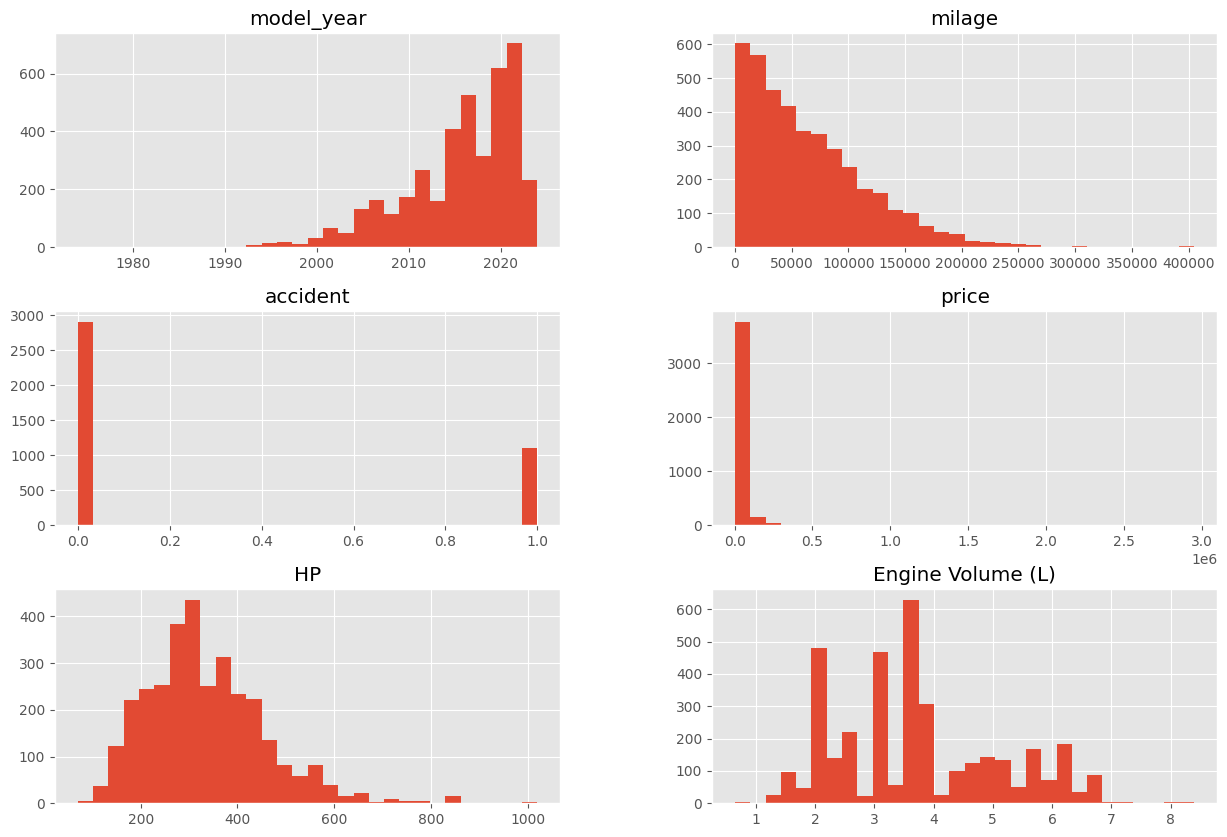

In [ ]:
df.hist(figsize=(15,10),bins=30)
plt.show()

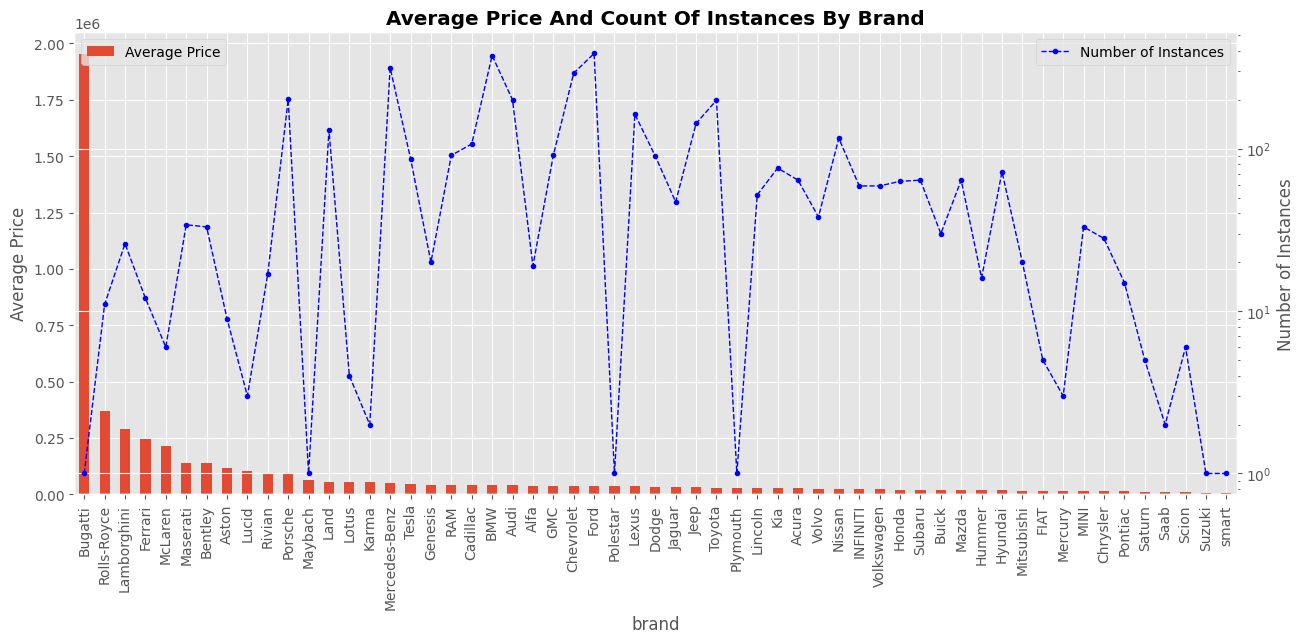

In [ ]:
g=df.groupby('brand').agg({'price':['mean','count']}).sort_values(('price','mean'),ascending=False)

fig,ax=plt.subplots(figsize=(15,6))
ax2=ax.twinx()
g.plot.bar(ax=ax,y=('price','mean'),label='Average Price')
g.plot.line(ax=ax2,y=('price','count'),color='blue',ls='--',lw=1,marker='.',label='Number of Instances')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_yscale('log')
ax.set_title('Average Price And Count Of Instances By Brand',fontweight='bold')
ax.set_ylabel('Average Price')
ax2.set_ylabel('Number of Instances')
plt.show()

In [ ]:
df.shape

(4009, 9)

In [ ]:
df=df.groupby('brand').filter(lambda x:x['price'].count()>15)

In [ ]:
df.shape

(3920, 9)

In [ ]:
for col in df.select_dtypes([int,float]).columns:
    col_mean=df[col].mean()
    col_std=df[col].std()
    lower_bound=col_mean-2*col_std
    upper_bound=col_mean+2*col_std

    df=df[(df[col]<upper_bound)&(df[col]>lower_bound)]

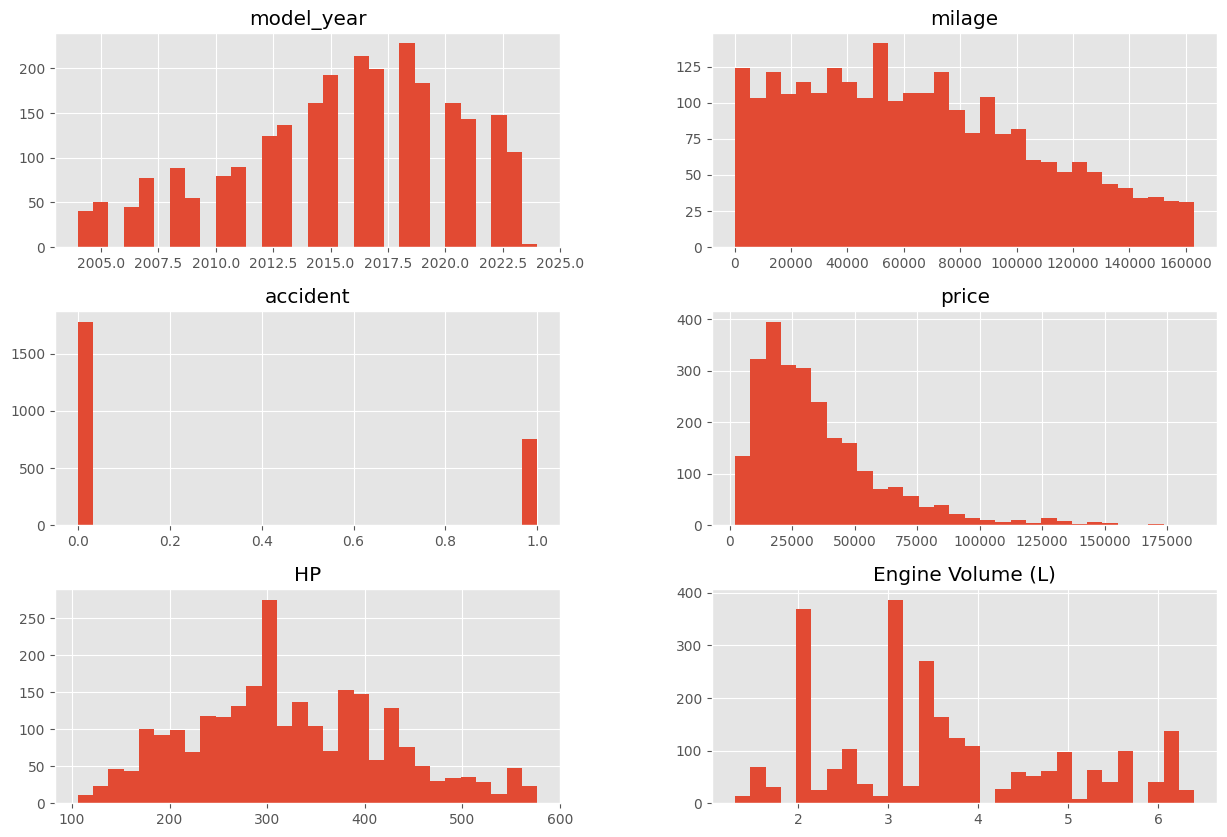

In [ ]:
df.hist(figsize=(15,10),bins=30)
plt.show()

In [ ]:
for col in df.select_dtypes('O').columns:
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

In [ ]:
df=df.dropna(subset=['HP','Engine Volume (L)'])

In [ ]:
df

,model_year,milage,accident,price,HP,Engine Volume (L),brand_Acura,brand_Alfa,brand_Audi,brand_BMW,brand_Bentley,brand_Buick,brand_Cadillac,brand_Chevrolet,brand_Chrysler,brand_Dodge,brand_Ford,brand_GMC,brand_Genesis,brand_Honda,brand_Hummer,brand_Hyundai,brand_INFINITI,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_Lincoln,brand_MINI,brand_Maserati,brand_Mazda,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Porsche,brand_RAM,brand_Subaru,brand_Toyota,brand_Volkswagen,brand_Volvo,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,transmission_False,transmission_True
0,2013,51000,1,10300,300.0,3.7,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
3,2015,88900,0,15500,354.0,3.5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
6,2017,84000,0,31000,292.0,2.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
8,2021,23436,0,41927,311.0,3.5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
12,2021,12500,0,53500,382.0,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,2021,32250,1,36000,260.0,2.4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True
4003,2018,53705,1,25900,241.0,2.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
4005,2022,10900,0,53900,349.0,3.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
4007,2020,33000,0,62999,450.0,3.5,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True


In [ ]:
X=df.drop(columns='price')
y=df['price']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,500,1000,2000],
            'max_depth':[3,5,8,10],
            'learning_rate':[0.01,0.05,0.1,0.15]}

grid_search_cv=GridSearchCV(estimator=XGBRegressor(),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=10)

grid_search_cv.fit(X_train,y_train)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-17026.221 total time=   0.1s
[CV 2/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-16609.196 total time=   0.1s
[CV 3/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-15590.449 total time=   0.1s
[CV 1/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 1/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-11679.900 total time=   0.3s
[CV 2/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 2/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-11807.247 total time=   0.3

In [ ]:
train_prediction=best_model.predict(X_train)
test_prediction=best_model.predict(X_test)

In [ ]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9651396203876219, 'MAE_train': 3225.4637786503367, 'RMSE_train': 4588.202721800709}
{'R2_test': 0.8440526768596185, 'MAE_test': 6111.8964974022665, 'RMSE_test': 10027.44928910356}


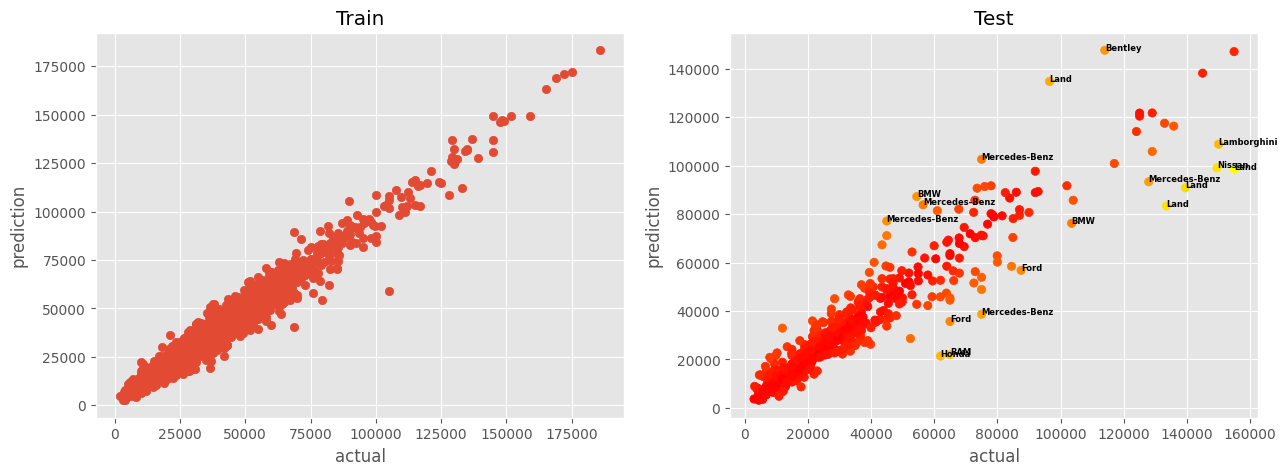

In [ ]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('actual')
ax1.set_ylabel('prediction')
ax1.set_title('Train')
ax2.scatter(y_test,test_prediction,c=(y_test-test_prediction).abs(),cmap='autumn')
ax2.set_xlabel('actual')
ax2.set_ylabel('prediction')
ax2.set_title('Test')


brands=X_test[X_test.columns[X_test.columns.str.contains('brand_')]].idxmax(axis=1).str.replace('brand_','')
absolute_error=(y_test-test_prediction).abs()
#plot text
for error,actual,prediction,brand in zip(absolute_error,y_test,test_prediction,brands):
    if error<mae_test-2*rmse_test or error>mae_test+2*rmse_test:
        ax2.text(actual,prediction,brand,fontweight='bold',size=6)

plt.show()

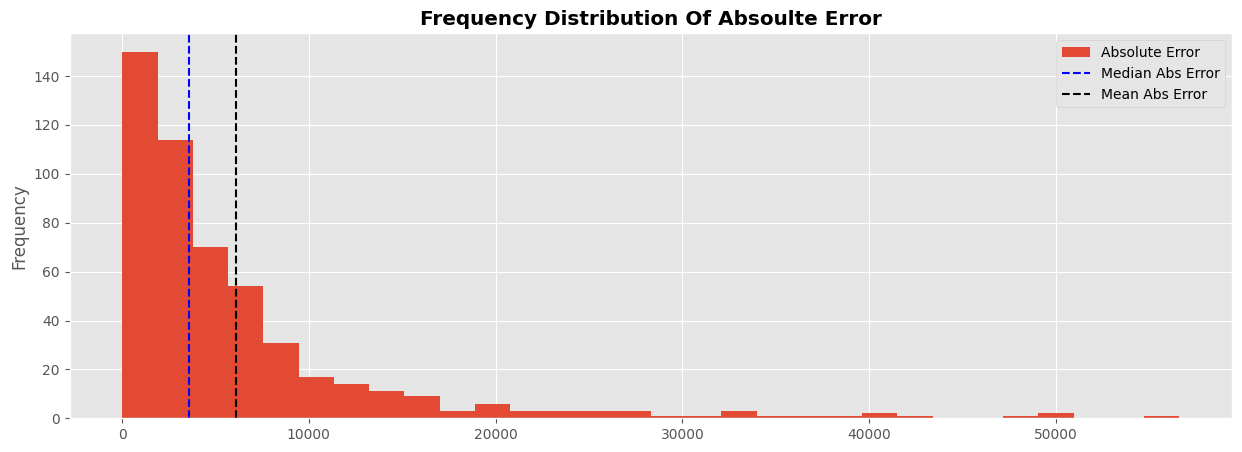

In [ ]:
fig,ax=plt.subplots(figsize=(15,5))
absolute_error.plot.hist(ax=ax,bins=30,label='Absolute Error')
ax.set_title('Frequency Distribution Of Absoulte Error',fontweight='bold')
median_abs_error=absolute_error.median()
ax.axvline(median_abs_error,label='Median Abs Error',color='blue',ls='--')
ax.axvline(mae_test,label='Mean Abs Error',color='black',ls='--')
ax.legend()
plt.show()

In [ ]:
X_test.head()

,model_year,milage,accident,HP,Engine Volume (L),brand_Acura,brand_Alfa,brand_Audi,brand_BMW,brand_Bentley,brand_Buick,brand_Cadillac,brand_Chevrolet,brand_Chrysler,brand_Dodge,brand_Ford,brand_GMC,brand_Genesis,brand_Honda,brand_Hummer,brand_Hyundai,brand_INFINITI,brand_Jaguar,brand_Jeep,brand_Kia,brand_Lamborghini,brand_Land,brand_Lexus,brand_Lincoln,brand_MINI,brand_Maserati,brand_Mazda,brand_Mercedes-Benz,brand_Mitsubishi,brand_Nissan,brand_Porsche,brand_RAM,brand_Subaru,brand_Toyota,brand_Volkswagen,brand_Volvo,fuel_type_Diesel,fuel_type_E85 Flex Fuel,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,transmission_False,transmission_True
2015,2015,51400,0,467.0,5.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
3270,2017,113294,1,245.0,2.0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
58,2014,37060,0,420.0,5.0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
327,2020,40000,0,523.0,4.4,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1298,2012,119000,0,211.0,2.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True


In [ ]:
X_test.columns

Index(['model_year', 'milage', 'accident', 'HP', 'Engine Volume (L)',
       'brand_Acura', 'brand_Alfa', 'brand_Audi', 'brand_BMW', 'brand_Bentley',
       'brand_Buick', 'brand_Cadillac', 'brand_Chevrolet', 'brand_Chrysler',
       'brand_Dodge', 'brand_Ford', 'brand_GMC', 'brand_Genesis',
       'brand_Honda', 'brand_Hummer', 'brand_Hyundai', 'brand_INFINITI',
       'brand_Jaguar', 'brand_Jeep', 'brand_Kia', 'brand_Lamborghini',
       'brand_Land', 'brand_Lexus', 'brand_Lincoln', 'brand_MINI',
       'brand_Maserati', 'brand_Mazda', 'brand_Mercedes-Benz',
       'brand_Mitsubishi', 'brand_Nissan', 'brand_Porsche', 'brand_RAM',
       'brand_Subaru', 'brand_Toyota', 'brand_Volkswagen', 'brand_Volvo',
       'fuel_type_Diesel', 'fuel_type_E85 Flex Fuel', 'fuel_type_Gasoline',
       'fuel_type_Hybrid', 'fuel_type_Plug-In Hybrid', 'transmission_False',
       'transmission_True'],
      dtype='object')

In [ ]:
X_test_new=X_test.copy()

dummie_column_keywords=['brand_','fuel_type_','transmission_']
for dummie_column_keyword in dummie_column_keywords:
    dummie_columns=X_test_new.columns[X_test_new.columns.str.contains(dummie_column_keyword)]
    dummie_to_series=X_test_new[dummie_columns].idxmax(axis=1).str.replace(dummie_column_keyword,'')
    dummie_to_series_df=pd.DataFrame({dummie_column_keyword:dummie_to_series})
    X_test_new=X_test_new.drop(columns=dummie_columns)
    X_test_new=pd.concat([X_test_new,dummie_to_series_df],axis=1)

In [ ]:
X_test_new['Absolute Error']=absolute_error

In [ ]:
X_test_new

,model_year,milage,accident,HP,Engine Volume (L),brand_,fuel_type_,transmission_,Absolute Error
2015,2015,51400,0,467.0,5.0,Lexus,Gasoline,True,6491.746094
3270,2017,113294,1,245.0,2.0,Ford,Gasoline,True,462.845703
58,2014,37060,0,420.0,5.0,Ford,Gasoline,False,5259.019531
327,2020,40000,0,523.0,4.4,BMW,Gasoline,False,11351.878906
1298,2012,119000,0,211.0,2.0,Audi,Gasoline,True,2041.081055
...,...,...,...,...,...,...,...,...,...
2080,2014,92000,1,445.0,4.4,BMW,Gasoline,False,3011.408203
1756,2020,6025,0,205.0,1.5,Honda,Gasoline,False,13299.738281
402,2010,121250,1,204.0,2.5,Lexus,Gasoline,True,2737.384766
533,2022,22985,0,169.0,2.5,Ford,Gasoline,True,4918.902344


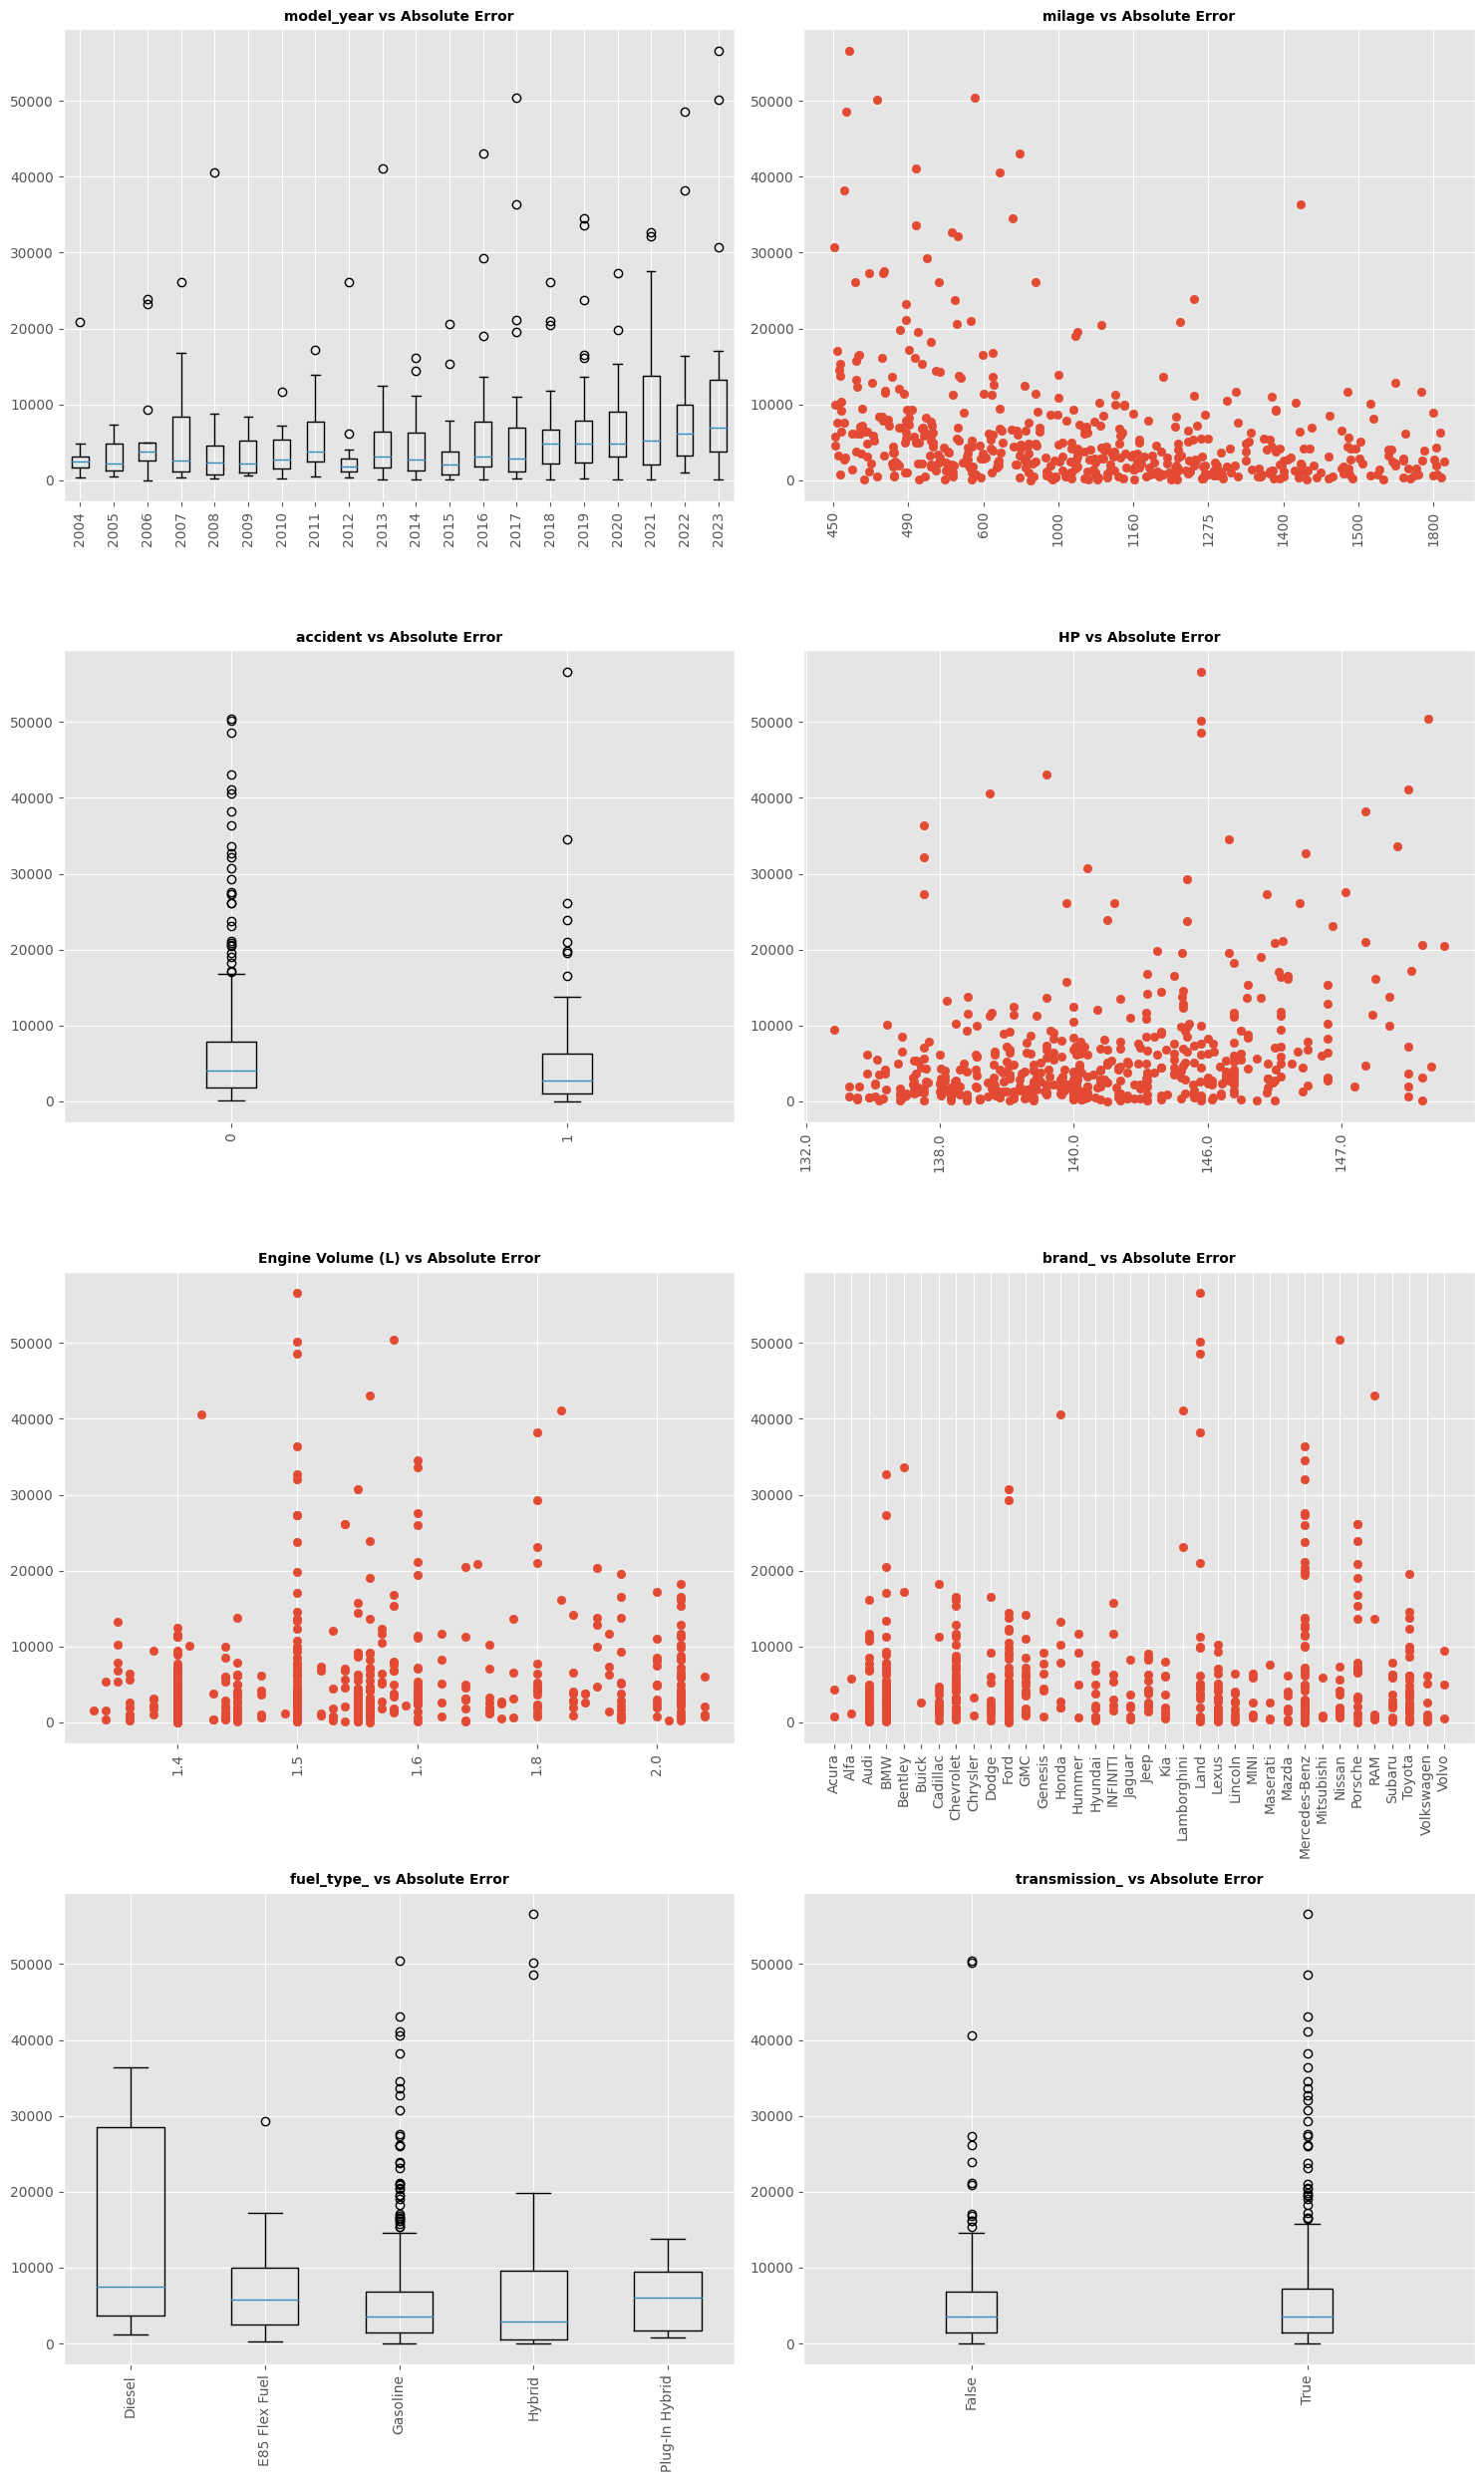

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(15,25))

for col,ax in zip(X_test_new.columns,axes.ravel()):
    X_test_new=X_test_new.sort_values(col)
    if X_test_new[col].nunique()<=25:
        ax.boxplot(labels=X_test_new[col].unique(),
                   x=[X_test_new[X_test_new[col]==label]['Absolute Error'] for label in X_test_new[col].unique()])
        ax.set_title(f'{col} vs Absolute Error',fontweight='bold',size=10)
        ax.set_xticklabels(X_test_new[col].unique(),rotation=90)
    else:
        ax.scatter(x=X_test_new[col],y=X_test_new['Absolute Error'])
        ax.set_title(f'{col} vs Absolute Error',fontweight='bold',size=10)
        ax.set_xticklabels(X_test_new[col].unique(),rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
from joblib import dump, load

dump(best_model, 'XGboost.joblib')

['XGboost.joblib']

In [ ]:
from google.colab import files

files.download('XGboost.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_test.dtypes

model_year                    int64
milage                        int64
accident                      int64
HP                          float64
Engine Volume (L)           float64
brand_Acura                    bool
brand_Alfa                     bool
brand_Audi                     bool
brand_BMW                      bool
brand_Bentley                  bool
brand_Buick                    bool
brand_Cadillac                 bool
brand_Chevrolet                bool
brand_Chrysler                 bool
brand_Dodge                    bool
brand_Ford                     bool
brand_GMC                      bool
brand_Genesis                  bool
brand_Honda                    bool
brand_Hummer                   bool
brand_Hyundai                  bool
brand_INFINITI                 bool
brand_Jaguar                   bool
brand_Jeep                     bool
brand_Kia                      bool
brand_Lamborghini              bool
brand_Land                     bool
brand_Lexus                 